# __Desafio - Random forest__ 
`by Benjamín Meneses`

## Requerimientos
- Para esta sesión trabajaremos con una base de datos sobre los precios de inmuebles en
la ciudad de Ames, Iowa. La base se compone de 2930 registros y contiene un gran
número de atributos.
- Nuestro objetivo es generar un modelo que prediga de forma adecuada los precios de
inmuebles, medidos con la variable `Sale_Price`.
- A diferencia de otras sesiones donde implementamos el preprocesamiento a mano,
ahora haremos uso de los archivos serializados en la sesión pasada.

## Ejercicio 1: Preparación del ambiente de trabajo
- Importe las librerías clásicas a utilizar.
- Para este ejercicio Random Forest de Regresión
- De manera adicional importe las funciones y clases necesarias para generar un
desempeño de métricas en problemas de regresión.
- Elimine la columna `'Unnamed: 0'` cuando cargue los datos.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, median_absolute_error, r2_score
from sklearn.ensemble import RandomForestRegressor

In [2]:
df = pd.read_csv('ames_housing.csv').drop(columns=['Unnamed: 0'])

## Ejercicio 2: Importación de archivos serializados
- Importe su modelo entrenado y sus conjuntos de entrenamiento y validación
serializados la sesión pasada y evalúe el desempeño del modelo de su compañero con
el suyo ¿Cuál es mejor? Si no puede ejecutar el modelo, comente cuáles pueden ser los
causantes.
- No es necesario que realice diagnósticos gráficos sobre el modelo, sólo reporte sus
métricas.
- Para importar un archivo serializado, puede ocupar la siguiente línea de código:
```python
import pickle
read_model = pickle.load(open("ignacio-soto-act07.sav","rb"))
```

Por [recomendación de scikit-learn](https://scikit-learn.org/stable/modules/model_persistence.html) se usará `joblib` como extensión de `pickle`

In [3]:
# Se usa joblib como extensión a pickle
from joblib import load

obj = load('pickle.joblib')

In [4]:
# Desenpaquetamos los datos de entrenamiento
X_train, X_test, y_train, y_test = obj['test_data']
# Desenpaquetamos el gridsearch obtenido
model = obj['model']


In [5]:
# Generamos las predicciones
y_hat = model.best_estimator_.predict(X_test)
# Analizamos las métricas
print(f'MSE: {mean_squared_error(y_test, y_hat)}')
print(f'MAE: {median_absolute_error(y_test, y_hat)}')
print(f'R2 Score: {r2_score(y_test, y_hat)}')

MSE: 1712560283.3989375
MAE: 16283.75
R2 Score: 0.7375350337402772


## Ejercicio 3: Evaluación Random Forest
- En base a los conjuntos de entrenamiento serializados, genere un modelo utilizando
`sklearn.ensemble.RandomForest` sin modificar hiper parámetros, sólo declarando la
semilla pseudoaleatoria.
- Reporte su desempeño y compárelo con su modelo de la sesión pasada, así como con
el de su compañero.


In [6]:
modelRF = RandomForestRegressor(random_state=19137).fit(X_train, y_train)
# Generamos las predicciones
y_hat_rf = modelRF.predict(X_test)
# Analizamos las métricas
print(f'MSE: {mean_squared_error(y_test, y_hat_rf)}')
print(f'MAE: {median_absolute_error(y_test, y_hat_rf)}')
print(f'R2 Score: {r2_score(y_test, y_hat_rf)}')

MSE: 986423557.9078702
MAE: 11645.73000000001
R2 Score: 0.8488218906196751


Vemos que el MSE cayó a casi la mitad, el MAE un tercio y el R2 notifica un aumento en la explicación del modelo en un ~11%

## Ejercicio 4: Reporte las métricas de desempeño
- Para afinar el comportamiento de nuestro modelo, evalúe su desempeño los siguientes
hiper parámetros:
  - `max_features`: `None`, `log2`, `sqrt`.
  - `n_estimators`: Evaluar entre 20 y 1000 en pasos de 50.
- Guarde la tasa de error en la exactitud medida con OOB.
- Grafique el comportamiento.


In [7]:
# generamos una serie de listas para guardar los valores
tmp_oob_none, tmp_oob_sqrt,tmp_oob_log2 = [], [], []
tmp_test_r2_none, tmp_test_r2_sqrt, tmp_test_r2_log = [], [], []
n_estimators = range(20, 1000, 50)

In [8]:
# para cada rango de modelos estimados
for i in n_estimators:
    # Implementamos una variante con todos los atributos
    voting_rf_none = RandomForestRegressor(
        n_estimators=i,
        max_features=None,
        oob_score=True,
        random_state=19137
    ).fit(X_train, y_train)
    # Implementamos una variante donde los atributos se escogen con sqrt
    voting_rf_sqrt = RandomForestRegressor(
        n_estimators= i,
        max_features="sqrt",
        warm_start=True,
        oob_score=True,
        random_state=19137
    ).fit(X_train, y_train)
    # Implementamos una variante donde los atributos se escogen con log
    voting_rf_log = RandomForestRegressor(
        n_estimators= i,
        max_features="log2",
        warm_start=True,
        oob_score=True,
        random_state=19137
    ).fit(X_train, y_train)
    # Estimamos el error en OOB
    tmp_oob_none.append(1 - voting_rf_none.oob_score_)
    tmp_oob_sqrt.append(1 - voting_rf_sqrt.oob_score_)
    tmp_oob_log2.append(1 - voting_rf_log.oob_score_)
    # Estimamos el error en la exactitud
    tmp_test_r2_none.append(1 - r2_score(y_test, voting_rf_none.predict(X_test)))
    tmp_test_r2_sqrt.append(1 - r2_score(y_test, voting_rf_sqrt.predict(X_test)))
    tmp_test_r2_log.append(1 - r2_score(y_test, voting_rf_log.predict(X_test)))

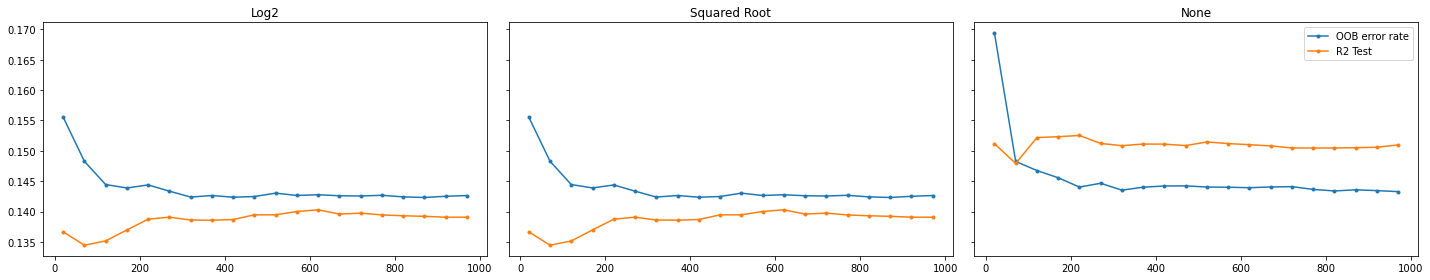

In [9]:
fig, axs = plt.subplots(1, 3, sharey=True, figsize=(20, 4))
axs[0].plot(list(n_estimators), tmp_oob_log2, '.-', label='OOB error rate')
axs[0].plot(list(n_estimators), tmp_test_r2_log, '.-', label='R2 Test')
axs[0].set_title('Log2')
axs[1].plot(list(n_estimators), tmp_oob_sqrt,'.-', label='OOB error rate')
axs[1].plot(list(n_estimators), tmp_test_r2_sqrt,'.-', label='R2 Test')
axs[1].set_title('Squared Root')
axs[2].plot(list(n_estimators), tmp_oob_none, '.-', label='OOB error rate')
axs[2].plot(list(n_estimators), tmp_test_r2_none,'.-', label='R2 Test')
axs[2].set_title('None')
plt.tight_layout()
plt.legend();

## Ejercicio 5: Refactoriza el modelo
- En base a la mejor combinación de hiper parámetros, reentrene el modelo y comente su
desempeño.

In [12]:
# Conseguimos el mejor valor para n_estimator
n_estimators[2]

120

Vemos que los mejores hiperparámetros son:
- `n_estimators`: 120
- `max_features`: `log2` o `sqrt`

Esto debido a que la combinación presenta un buen r2_score (notar que se grafica `1 - r2_score(...)`) además de un bajo OOB score. Si bien el OOB score no es el mas bajo de todas la combinaciónes, se mantiene dentro de un rango razonable de este. 

In [13]:
bestModelLog = RandomForestRegressor(random_state=19137, n_estimators=120, max_features='log2').fit(X_train, y_train)
bestModelSqrt = RandomForestRegressor(random_state=19137, n_estimators=120, max_features='sqrt').fit(X_train, y_train)

# Generamos las predicciones
y_hat_best_log = bestModelLog.predict(X_test)
y_hat_best_sqrt = bestModelSqrt.predict(X_test)
# Analizamos las métricas
print('Metricas usando max_features = log2')
print(f'MSE: {mean_squared_error(y_test, y_hat_best_log)}')
print(f'MAE: {median_absolute_error(y_test, y_hat_best_log)}')
print(f'R2 Score: {r2_score(y_test, y_hat_best_log)}')
print("="*20)
# Analizamos las métricas
print('Metricas usando max_features = sqrt')
print(f'MSE: {mean_squared_error(y_test, y_hat_best_sqrt)}')
print(f'MAE: {median_absolute_error(y_test, y_hat_best_sqrt)}')
print(f'R2 Score: {r2_score(y_test, y_hat_best_sqrt)}')

Metricas usando max_features = log2
MSE: 881886582.7333378
MAE: 11295.208333333328
R2 Score: 0.8648431039620877
Metricas usando max_features = sqrt
MSE: 881886582.7333378
MAE: 11295.208333333328
R2 Score: 0.8648431039620877


Vemos que todas las métricas mejoraron, además, notamos que los valores conseguido con `max_features` para `log2` y `sqrt` son idénticas. Esto es claro pues como nuestra base de entrenamiento tiene sólo 10 atributos, tanto el logarítmo en base 2 como la raíz cuadrada de 10 es ~3, redondeando al mismo `max_features=3`